## Import libraries

In [20]:
import numpy as np
import pandas as pd
import os
import re
import cv2
from matplotlib import pyplot as plt
import torch

print("Pytorch: " + "GPU" if torch.cuda.is_available() else "CPU")

Pytorch: GPU


In [21]:
model = torch.hub.load("./yolov5", "custom", source='local', path="./modelSaves/best.pt", force_reload=True)

YOLOv5 🚀 v7.0-82-gcec1b9b Python-3.8.15 torch-1.7.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [22]:
test = pd.read_csv("./test.csv")
test

,id,bbox,path
0,7583,"[[0.9198437500000001, 0.277125, 0.114343750000...",data/000000007583.jpg
1,22741,"[[0.3677265625, 0.5710077519379845, 0.04942187...",data/000000022741.jpg
2,12233,"[[0.9705444126074497, 0.12615104166666666, 0.0...",data/000000012233.jpg
3,10986,"[[0.7428337236533957, 0.27931249999999996, 0.5...",data/000000010986.jpg
4,6074,"[[0.2950703125, 0.5135206869633099, 0.07654687...",data/000000006074.jpg
5,19176,"[[0.46889843749999993, 0.49163888888888885, 0....",data/000000019176.jpg
6,10472,"[[0.22315000000000002, 0.62784, 0.1395, 0.2148...",data/000000010472.jpg
7,5294,"[[0.619796875, 0.06710250201775625, 0.03565625...",data/000000005294.jpg
8,24778,"[[0.7538828125, 0.5708878504672897, 0.06385937...",data/000000024778.jpg
9,17945,"[[0.50259375, 0.6572037037037037, 0.0693749999...",data/000000017945.jpg


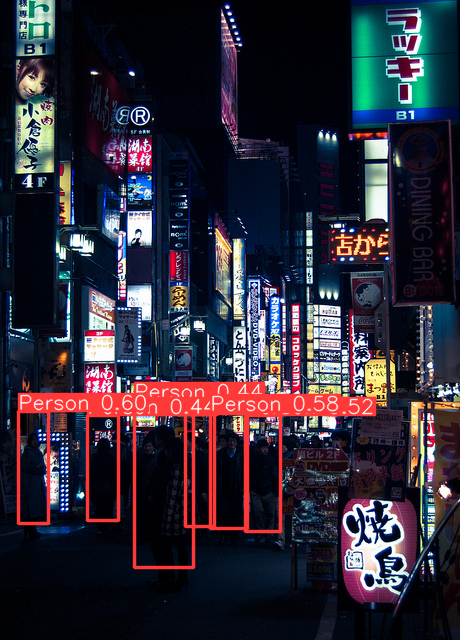

In [58]:
path_ = test.iloc[32]["path"]
# res = model(cv2.imread(path_))
res = model(path_)
res.show()

In [59]:
res = pd.DataFrame(res.xywh[0].cpu().numpy(), columns=["x", "y", "w", "h", "confidence", "label"])

In [60]:
print(res.sort_values(by=["confidence"], ascending=False))

            x           y          w           h  confidence  label
0   33.801765  467.752899  29.729591  111.785950    0.601039    0.0
1  229.179901  470.395782  37.261047  116.443909    0.578224    0.0
2  263.372620  473.286285  34.845139  116.325989    0.518897    0.0
3  103.118446  468.236542  30.964676  105.440125    0.438244    0.0
4  164.290421  484.397522  58.606964  167.169037    0.436874    0.0
5  199.969269  470.629211  28.320007  111.697418    0.395131    0.0


### handle results configuration

In [61]:
res["x"] = res.apply(lambda x:x["x"]+(x["w"]/2), axis=1)
res["y"] = res.apply(lambda x:x["y"]+(x["h"]/2), axis=1)
min_w = res["w"].min()
res["w"] = res.apply(lambda x:(x["w"]/min_w)**2, axis=1)

res = res[res["confidence"]>=0.15][["x", "y", "w"]]
print(res)

            x           y         w
0   48.666561  523.645874  1.102024
1  247.810425  528.617737  1.731105
2  280.795189  531.449280  1.513902
3  118.600784  520.956604  1.195491
4  193.593903  567.982040  4.282642
5  214.129272  526.477921  1.000000


## Implement clustering

In [62]:
RAND_SEED = 3362
from sklearn.cluster import KMeans

In [63]:
kmeans = KMeans(
    n_clusters = 1, 
    init = 'random',
    n_init = 10,
)

In [64]:
arr = res.to_numpy()
kmeans.fit(arr)

KMeans(init='random', n_clusters=1)

In [65]:
preds = kmeans.predict(arr)

## Visualize Clustering result

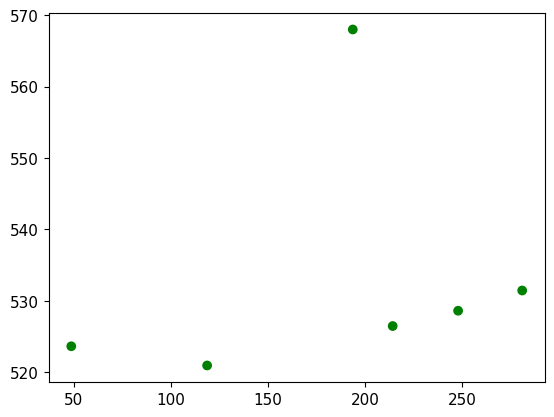

In [66]:
# Visualizing predictions with Seaborn pairplot
import matplotlib.pyplot as plt
%matplotlib inline

colors_ = ["green", "blue", "red", "yellow", "purple"]
plt.scatter(arr[:,0], arr[:,1], c=[colors_[i] for i in preds.tolist()])

plt.show()

## Determine cluster density

In [67]:
tmp = (pd.DataFrame(((res[["x", "y", "w"]].groupby(by=preds).max() - res[["x", "y", "w"]].groupby(by=preds).min()).apply(lambda x: x.x * x.y * x.w, axis=1)), columns=["w"])).rename(columns={"w":"area"})
density = ((pd.DataFrame(res[["w"]].groupby(by=preds).size(), columns=["area"])/tmp)/(res[["w"]].groupby(by=preds).mean()).rename(columns={'w':"area"})).rename(columns={"area":"density"})
density.replace([np.inf, -np.inf], 0, inplace=True)

Create Label to identify if area is crowded
    Threshold to determine if area is crowded

In [68]:
crowded = density.copy()
crowded["label"] = density.apply(lambda x: x>5.910477e-07)
crowded

,density,label
0,0.000093,True
